# 02_modeling_with_path_fix
Prophet modeling with holiday effects.

In [8]:
import sys, os
sys.path.append(os.path.abspath('..'))
print('Added project root to sys.path:', os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from prophet import Prophet
from src.holidays_us import build_holidays
from src.train import evaluate


Added project root to sys.path: C:\Projects\hypermarket-holiday-forecast


## Load and aggregate Walmart Recruiting train.csv

In [9]:
DATA_DIR = Path('../data/raw')
csv_path = DATA_DIR / 'train.csv'
df = pd.read_csv(csv_path)
assert 'Date' in df.columns and 'Weekly_Sales' in df.columns
df['Date'] = pd.to_datetime(df['Date'])
ts = (
    df.groupby('Date', as_index=False)['Weekly_Sales']
      .sum()
      .sort_values('Date')
      .rename(columns={'Date':'ds','Weekly_Sales':'y'})
)
ts.head()


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


## Train/Validation split and fit Prophet

In [10]:
holdout_weeks = 12
train_ts = ts.iloc[:-holdout_weeks].copy()
valid_ts = ts.iloc[-holdout_weeks:].copy()
holidays = build_holidays(int(train_ts['ds'].dt.year.min()), int(train_ts['ds'].dt.year.max()))
m = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(train_ts)
future = m.make_future_dataframe(periods=holdout_weeks, freq='W-FRI')
forecast = m.predict(future)
pred_valid = forecast.set_index('ds').loc[valid_ts['ds']][['yhat']].reset_index()
metrics = evaluate(valid_ts['y'].values, pred_valid['yhat'].values)
metrics


20:03:15 - cmdstanpy - INFO - Chain [1] start processing
20:03:15 - cmdstanpy - INFO - Chain [1] done processing


{'MAE': 1278504.8975014712,
 'RMSE': 1432126.065151195,
 'MAPE%': 2.7513568671561255}

## Save plots and outputs

Saved to: C:\Projects\hypermarket-holiday-forecast\figures and C:\Projects\hypermarket-holiday-forecast\reports


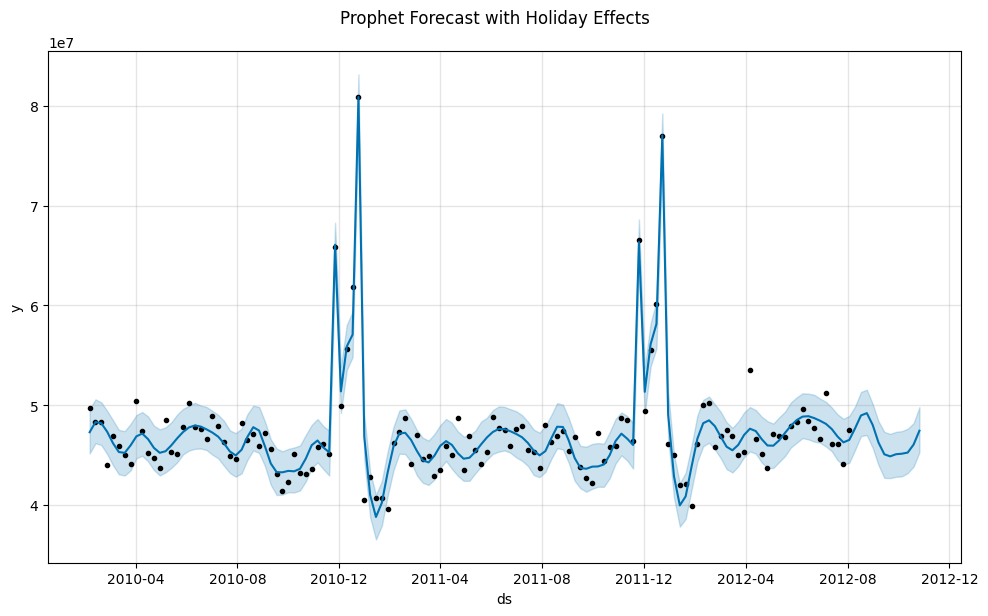

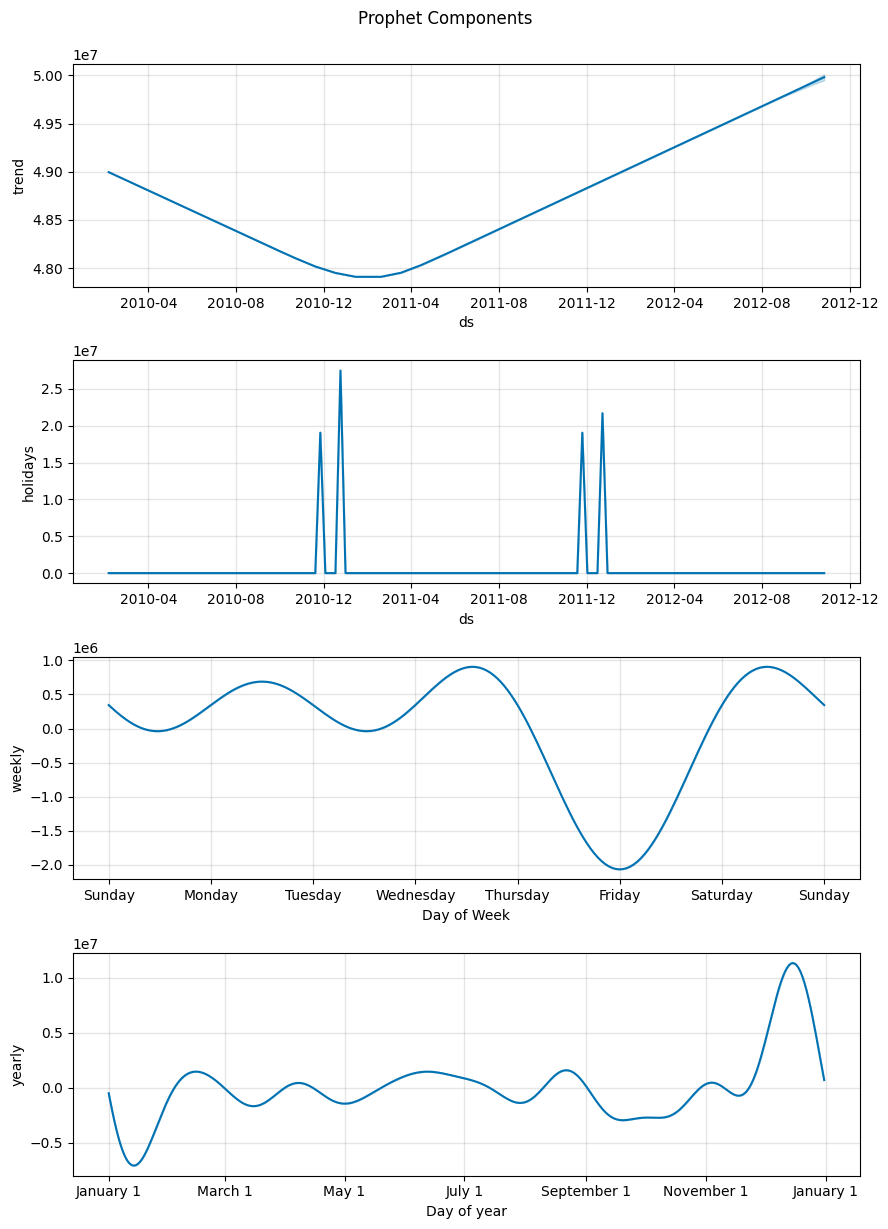

In [11]:
# Project root is the parent of the notebooks folder
ROOT = Path("..").resolve()

# Ensure output folders exist
FIG_DIR = ROOT / "figures"
REP_DIR = ROOT / "reports"
FIG_DIR.mkdir(parents=True, exist_ok=True)
REP_DIR.mkdir(parents=True, exist_ok=True)

# Save figures
fig1 = m.plot(forecast)
fig1.suptitle('Prophet Forecast with Holiday Effects', y=1.02)
fig1.savefig(FIG_DIR / "prophet_forecast.png", bbox_inches="tight")

fig2 = m.plot_components(forecast)
fig2.suptitle('Prophet Components', y=1.02)
fig2.savefig(FIG_DIR / "prophet_components.png", bbox_inches="tight")

# Save CSV outputs (optional)
from datetime import datetime
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(REP_DIR / f"forecast_{stamp}.csv", index=False)
import pandas as pd
pd.DataFrame([metrics]).to_csv(REP_DIR / f"metrics_{stamp}.csv", index=False)

print("Saved to:", FIG_DIR, "and", REP_DIR)
